In [2]:
import yt 
yt.mylog.setLevel(50)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ~/project/FLASH4.3_3/object/

/global/project/projectdirs/astro250/doris/FLASH4.3_3/object


In [3]:
# # Simple script for calculating sink parameters 
# rho = 1.0e-16
# G = 6.67e-8
# c_s  = 28730.5 #cm/s (based on T = 10K) 
# jeans_length = sqrt(pi*c_s**2/(G*rho))
# boxlen =1e19
# lev_max = 5
# cell_size = boxlen/(2**(lev_max+2))
# rho_threshold = pi*c_s**2/(4*G*jeans_length**2)
# r_acc = 2.5*cell_size
# rho_threshold=  pi*c_s**2/(4*G*r_acc**2)
# print "sink_density_thresh = ", rho_threshold
# print "sink_accretion_radius = ", r_acc
# print "sink_softening_radius = ", r_acc

# SinkMomTest

To get the sink particle activated, we need a density rise, which we previously didn't get. But now if we use a huge fattening factor, we should get a couple orders of magnitude of density rise really quick 

In [5]:
import yt
from yt.mods import *
yt.funcs.mylog.setLevel(50) #coerce output null
def plot_dens(i,velocity=False):
    ds = yt.load("SMT_hdf5_chk_{}".format(str(i).zfill(4)))
    physical_quantity="density"
    slc = yt.SlicePlot(ds, "z",physical_quantity)#,center=(0.5,0.5,0.5))
    slc.set_figure_size(5)
#     slc.annotate_grids()
    if velocity: slc.annotate_velocity()
    slc.set_cmap("all","rainbow")
#     slc.set_zlim(physical_quantity, 5.0e-20,1.0e-16)
    slc.show()


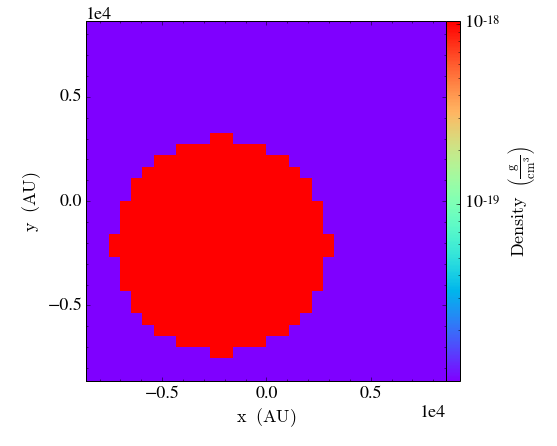


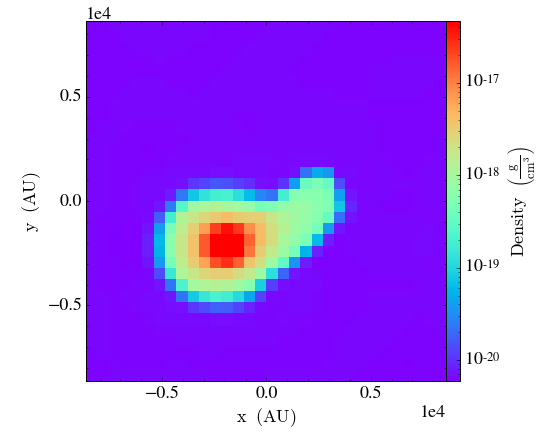


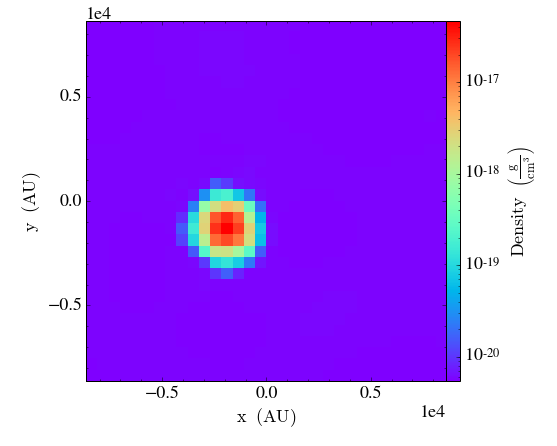


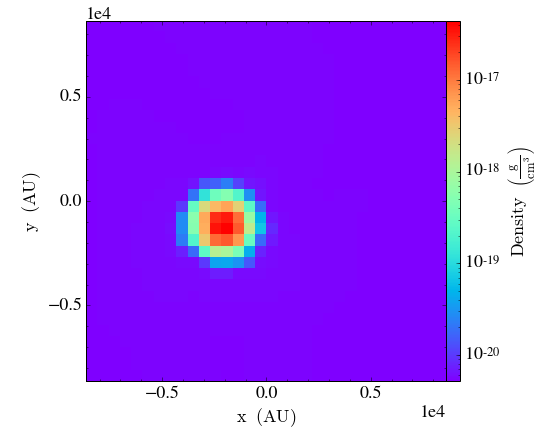


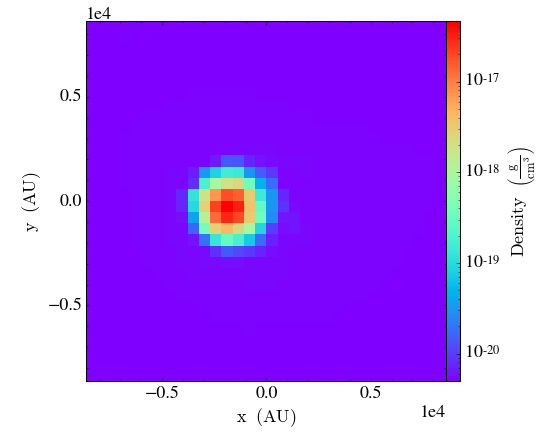


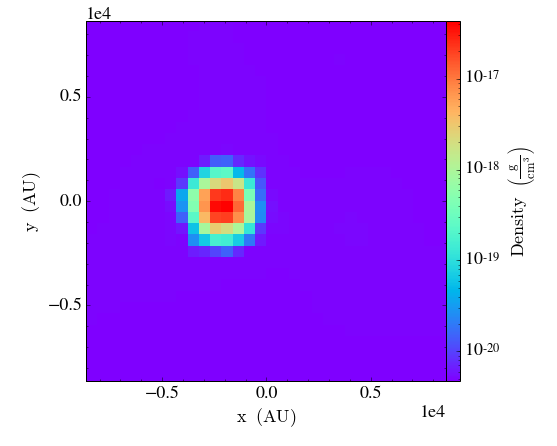


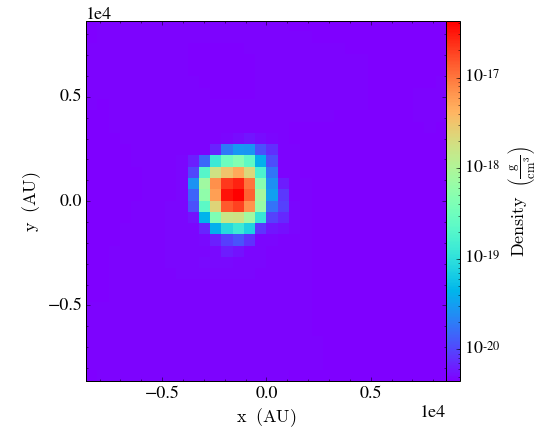


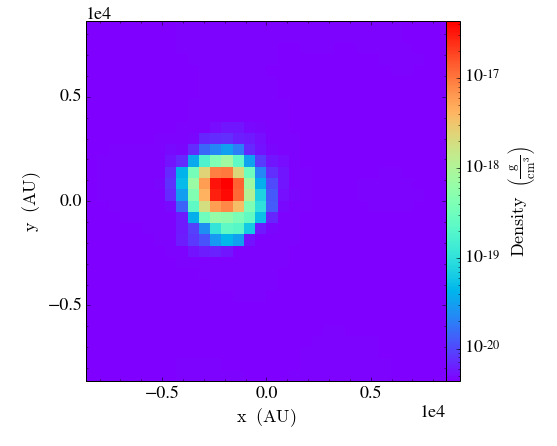


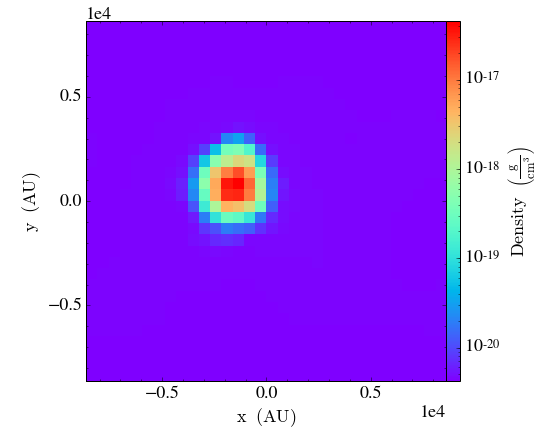


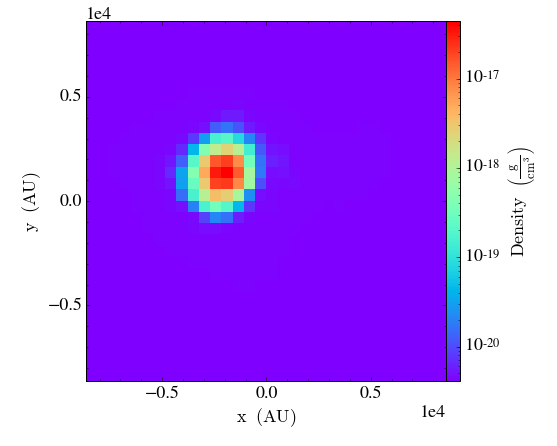

In [7]:
for i in np.arange(10):
    plot_dens(i)

If we look into utils we find some python script that reads SMT.dat which seems to contain numerical information about some physical variables. And some IDL script that reads the part files 
There's also : 

sink_ewald.txt: contain dx,dy,dz, and force correction in all directions (not too sure what this is ... )  

sinks_evol.dat : contain x,v,a kinematic information and accretion rate for each pcl 

In [8]:
ds = yt.load("SMT_hdf5_chk_{}".format(str(i).zfill(4)))
dd = ds.all_data()
print dd["particle_position_x"]
print dd["particle_position_y"]
print dd["particle_position_z"]

[ -2.97649795e+16   6.45817720e+16] code_length
[  1.99679826e+16   1.53885190e+16] code_length
[  4.26540749e+14   5.56089046e+14] code_length


so this is good they have this information inside the chk files. But slc.annotate_particles() still doesn't work (no particleCallback) 

yt says "but particle files are not currently directly loadable by themselves, due to the fact that they typically lack grid information. "

# ----------------------------------------------------------------------------------

TODO: Now try to analyze the particle data, once I figured that out I could look at the COnfig and flash.par and compared to my sink test to see what I'm doing wrong '

after fixing this, it runs! 

we do get a sink_evol.dat, but not a sink_ewald.txt . Its okay I dont really know what that is anyways..

In [4]:
import yt
from yt.mods import *
yt.funcs.mylog.setLevel(50) #coerce output null
def plot_dens(i,velocity=False):
    ds = yt.load("sod_hdf5_chk_{}".format(str(i).zfill(4)))
    physical_quantity="density"
    slc = yt.SlicePlot(ds, "z",physical_quantity)#,center=(0.5,0.5,0.5))
    slc.set_figure_size(5)
#     slc.annotate_grids()
    if velocity: slc.annotate_velocity()
    slc.set_cmap("all","rainbow")
#     slc.set_zlim(physical_quantity, 5.0e-20,1.0e-16)
    slc.show()


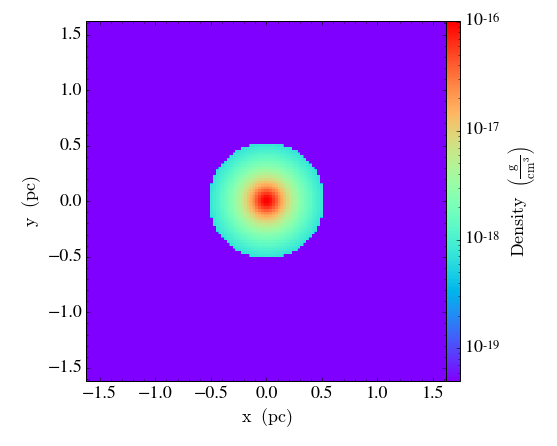


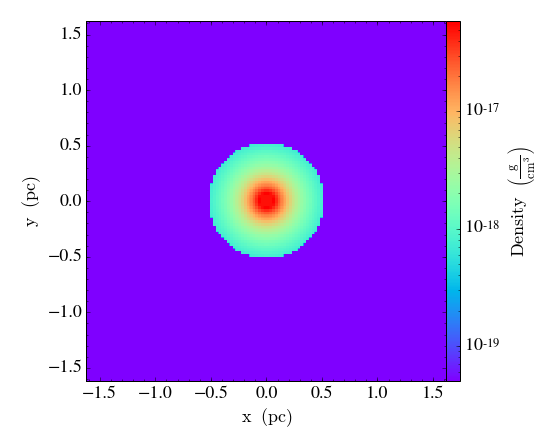


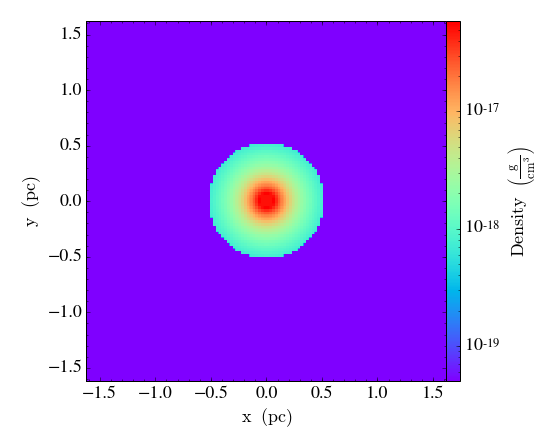


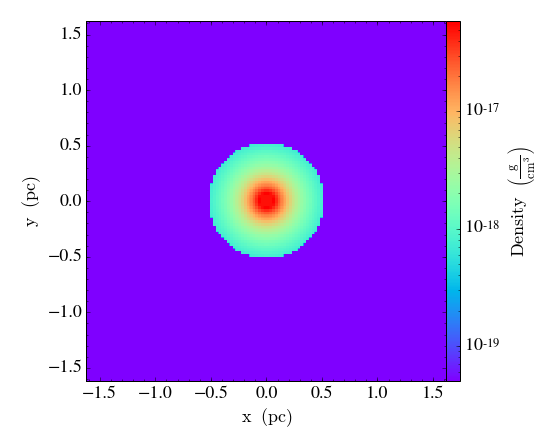


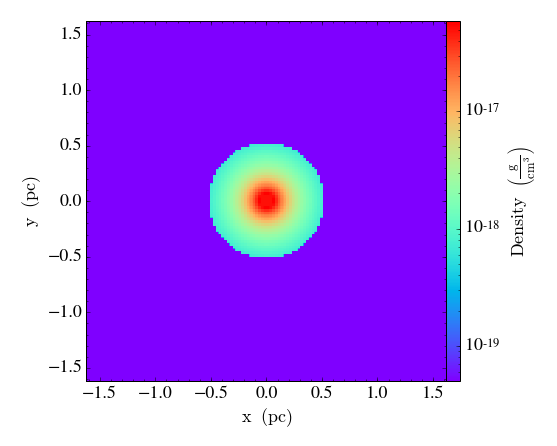


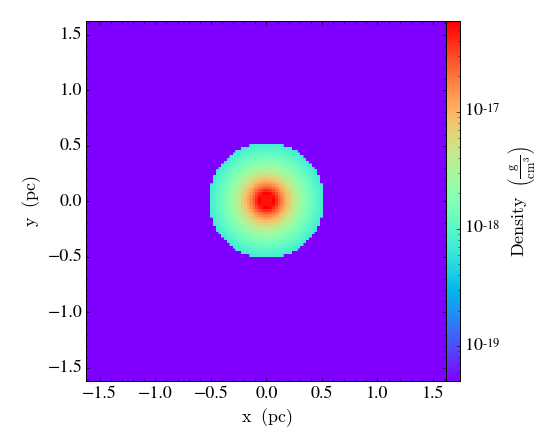


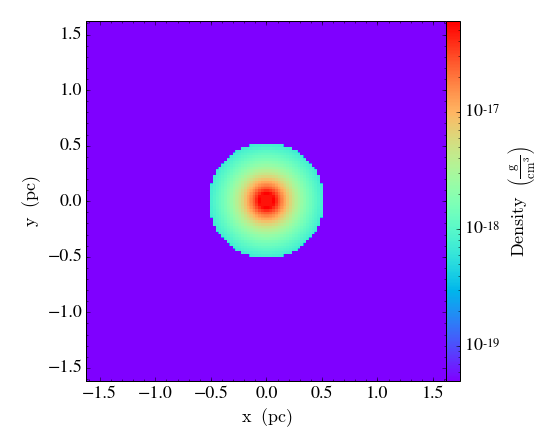


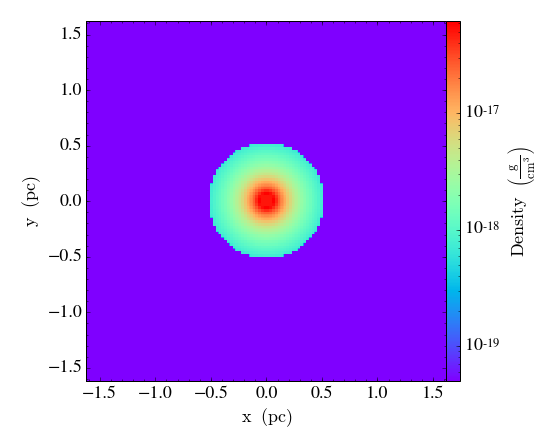


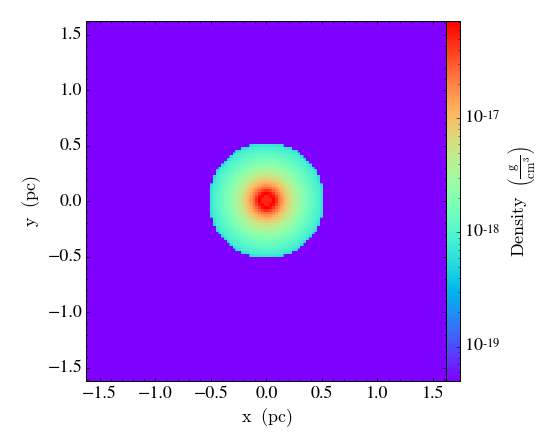


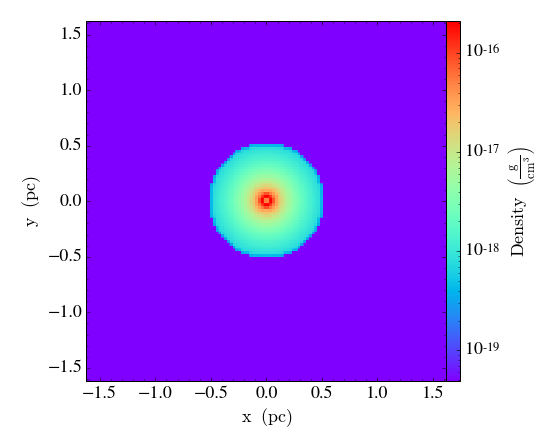

In [5]:
for i in np.arange(10):
    plot_dens(i)

So I need to analyze sinks_evol.dat on my own, thankfully this is not in HDF5

In [10]:
data =np.loadtxt("sinks_evol.dat",skiprows=1)

In [21]:
! sed -n '1{p;q}' sinks_evol.dat 

     [00]part_tag         [01]time         [02]posx         [03]posy         [04]posz         [05]velx         [06]vely         [07]velz       [08]accelx       [09]accely       [10]accelz        [11]anglx        [12]angly        [13]anglz         [14]mass         [15]mdot        [16]ptime


In [22]:
data[:,0]

array([ 65536.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.,  65537.,  65537.,  65537.,  65537.,  65537.,
        65537.,  65537.])

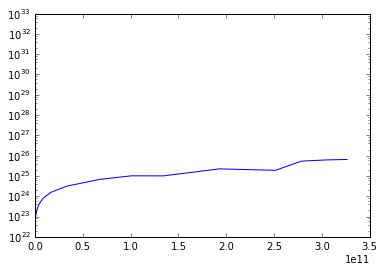

In [28]:
t = data[:,1]
mdot = data[:,15]
plt.semilogy(t,mdot)

I looked at thee MRPlots and decided that it would be better to use the fattening_factor = 100 run so I reran this but it crashed at segfault and warn: 

 pt_sinkAccelSinksOnSinks: grav softening type = spline
 Particles_sinkAdvanceParticles: #subcycles:           1
SinkParticles: You have set the sink particle accretion radius to   2.50 * (1+redshift) cells at the highest level of refinement.

The only thing that I changed was the fattening factor and the plot output times by a factor of 10 (that should not affect it) 

---> possibly because this density difference changes what we should be putting down as acccretion radius or accretion threshold density 

Now changing it back to factor   = 1000 again it works . So i simply increased the timestepping here to see if I could get to the time of core formation 


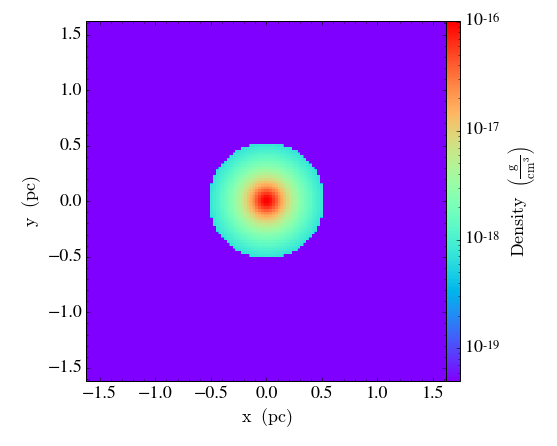


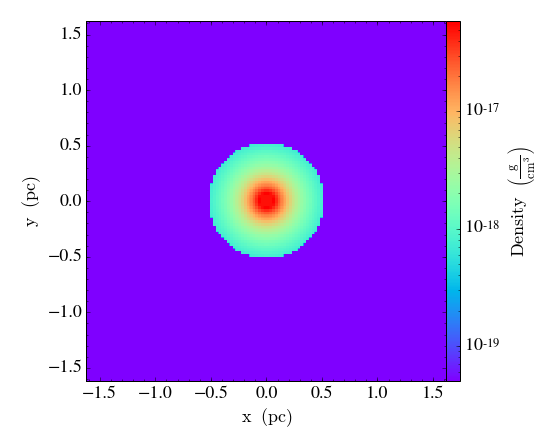


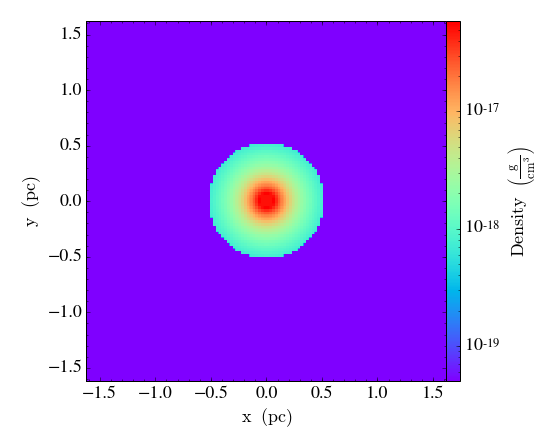


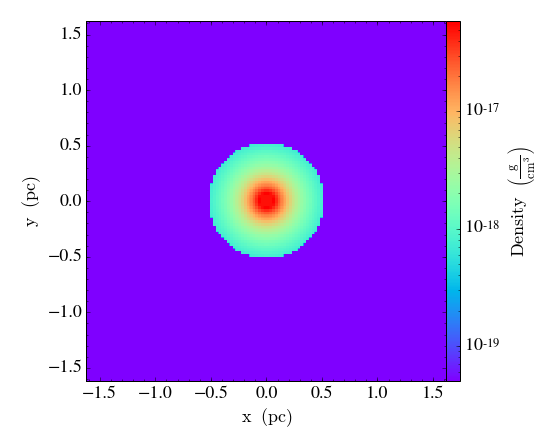


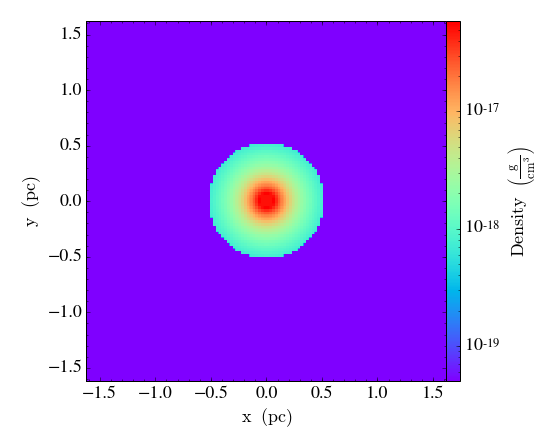


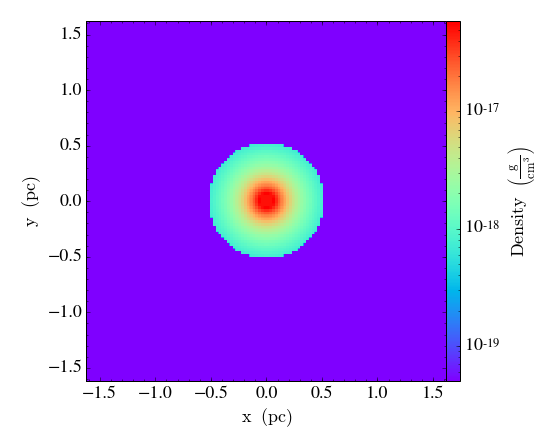


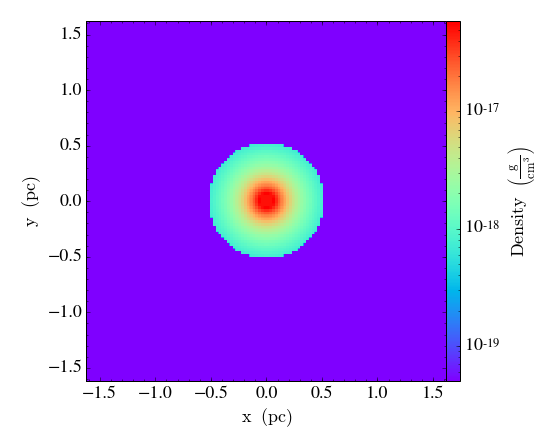


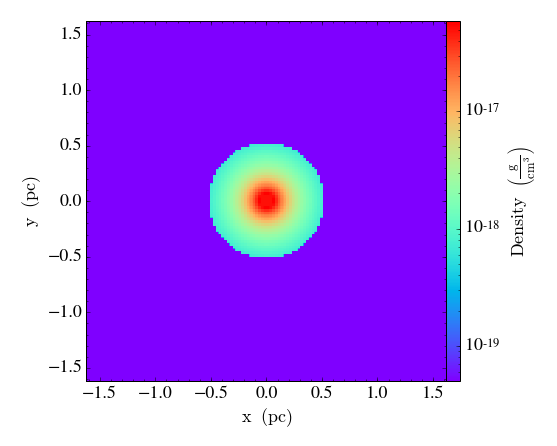


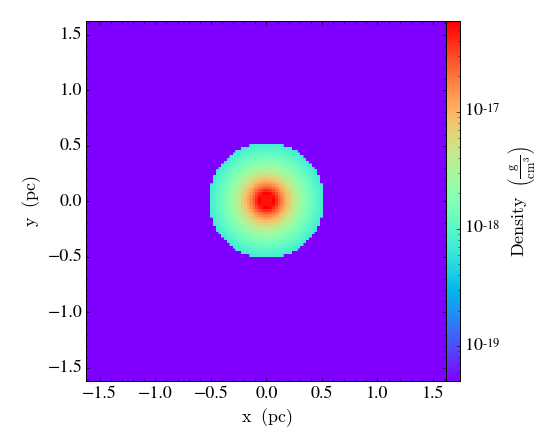


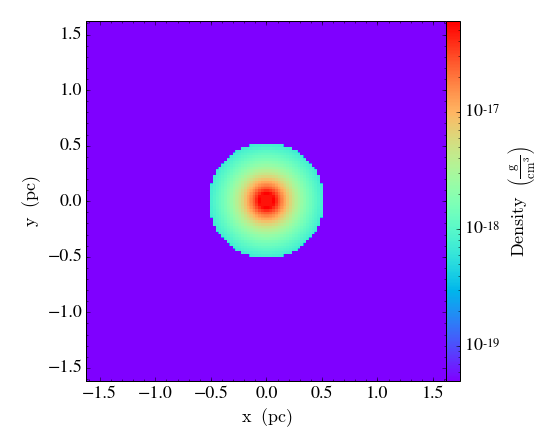


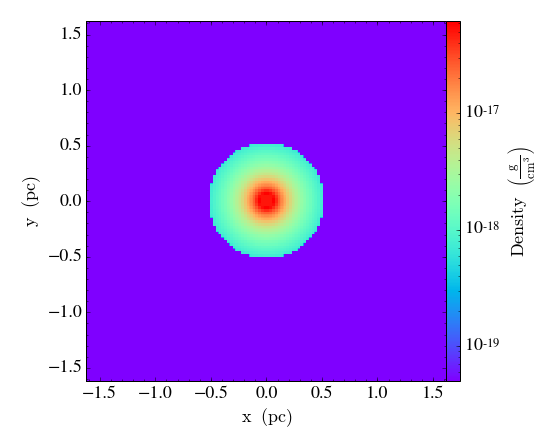


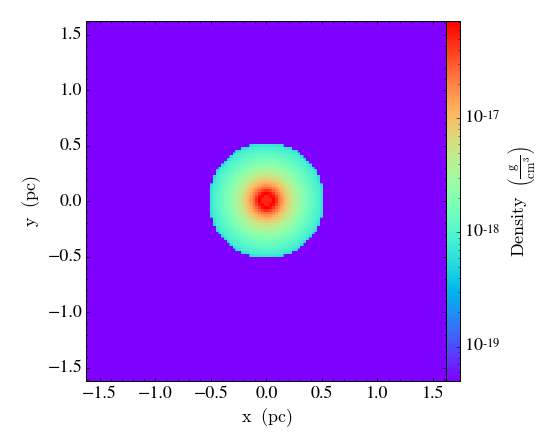


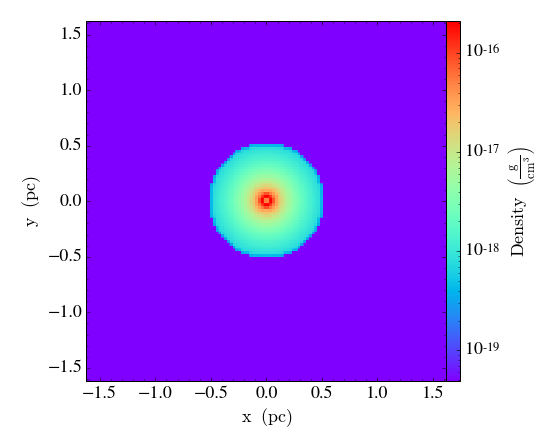


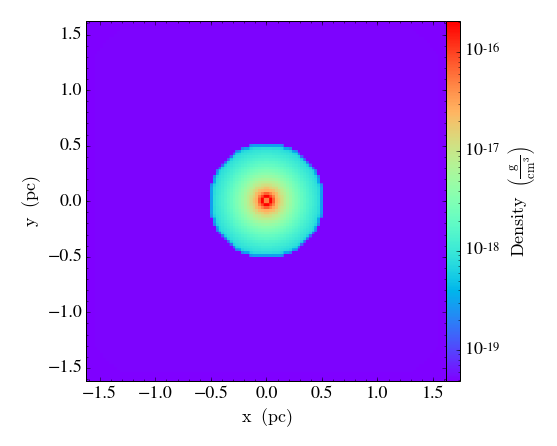

In [29]:
for i in np.arange(14):
    plot_dens(i)

## Sink Questions : 

-  How to put in the sink after t= 0 at some specified time ? 

- When I change the density enhancement inside flash.par for the same problem, the code crashes (segfaults): 

    pt_sinkAccelSinksOnSinks: grav softening type = spline Particles_sinkAdvanceParticles: #subcycles: 1 SinkParticles: You have set the sink particle accretion radius to 2.50 * (1+redshift) cells at the highest level of refinement.

   (371146.out) 
   
- Inside sinks_evol.dat,
    - how is it possible to have one sink particle in the beginning, but that particle only show up in the initial timestep, disappears at later times (merging?) 
    - what is ptime? 

- 